# Tutorial 8: UE_3_corridor_Network

This dataset shows two scenarios of network, with different modes and demand period. And this full text will cover the following topics:
* Network data: reading and presentation of core data files
* The primary programme: running the DTA module of path4gmns
* Results: reading and analysing the outcomes

Make sure you have the following libraries installed:

In [1]:
import pandas as pd
import path4gmns as pg
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os

path4gmns, version 0.9.7


## 1. Network data
Before proceeding with the path4GMNS-DTA, you can use pandas to read the input data, to see its format or to make changes as your actual requirements.<br>
The following code reads the key input data as a demonstration.<br>

Key data outline:
* node.csv, link.csv: define the physical network
* demand.csv : defines the demand of passengers on each OD pair, which can be extracted by demand_file_list.csv
* scenario_index_list.csv : defines scenario name, scenario description and activation state
* demand_period.csv
* demand_file_list.csv : defines demand type, period, and format type, and you can set the demand message for different conditions in it( for scenarios, modes or time period）
* mode_type.csv : defines attributes of each type of agent, including vot (unit: dollar per hour) and pce

In [2]:
mini_path = "./08_UE_3_corridor_Network/minimum_input/"
node = pd.read_csv(mini_path+'node.csv') 
link = pd.read_csv(mini_path+'link.csv')  
demand = pd.read_csv(mini_path+'demand.csv')  #OD-demand
scenario = pd.read_csv(mini_path+'scenario_index_list.csv')
demand_period = pd.read_csv(mini_path+'demand_period.csv')  
demand_files = pd.read_csv(mini_path+'demand_file_list.csv') 
mode_type = pd.read_csv(mini_path+'mode_type.csv')

In [3]:
node

,node_id,x_coord,y_coord,zone_id
0,1,0.0,-0.1,1
1,2,40.3,0.1,2
2,3,19.8,14.8,0
3,4,19.7,-9.7,0


In [4]:
link

,link_id,from_node_id,to_node_id,link_type,dir_flag,length,lanes,free_speed,capacity
0,1,1,4,3,1,15000,1,60,3000
1,2,4,2,3,1,15000,1,60,3000
2,3,1,3,3,1,30000,1,60,3000
3,4,3,2,3,1,30000,1,60,3000


In [5]:
demand

,o_zone_id,d_zone_id,volume
0,1,2,3000


In file scenario_index_list.csv, two scenes 0(base) and 1(info) are defined, corresponding to the setting in demand_file_list.csv. And when the attribute **activate** in this file is set to 1, the scene is valid and will be processed by the program.

In [6]:
scenario

,first_column,scenario_index,year,scenario_name,scenario_description,activate
0,0,0,2025,base,base,1
1,0,1,2025,info,info,1


For each period, it may has different peak time and deamand volume.

In [7]:
demand_period

,first_column,demand_period_id,demand_period,notes,time_period,peak_time
0,0,1,am7,weekday,0700_0800,730
1,0,2,am8,weekday,0800_0900,830
2,0,3,am9,weekday,0900_1000,930
3,0,4,am10,weekday,1000_1100,1030


In demand_file_list.csv, you can specify different files and scales for different time period, sceanrio and mode type, just as shown below.

In [8]:
demand_files

,first_column,file_sequence_no,scenario_index_vector,file_name,demand_period,mode_type,format_type,scale_factor,departure_time_profile_no,comment
0,0,1,0,demand.csv,am7,auto,column,0.9,1,NaN
1,0,2,0,demand.csv,am8,auto,column,0.9,1,NaN
2,0,3,0,demand.csv,am9,auto,column,0.9,1,NaN
3,0,4,0,demand.csv,am10,auto,column,0.9,1,NaN
4,0,5,0,demand.csv,am7,info,column,0.1,1,NaN
5,0,6,0,demand.csv,am8,info,column,0.1,1,NaN
6,0,7,0,demand.csv,am9,info,column,0.1,1,NaN
7,0,8,0,demand.csv,am10,info,column,0.1,1,NaN
8,0,9,1,demand.csv,am7,auto,column,0.5,1,NaN
9,0,10,1,demand.csv,am8,auto,column,0.5,1,NaN


In [9]:
mode_type

,first_column,mode_type,mode_type_index,name,vot,multimodal_dedicated_assignment_flag,person_occupancy,headway_in_sec,DTM_real_time_info_type,activate
0,0,auto,0,auto,10,1,1,1.5,0,1
1,0,info,1,info,10,0,1,1.0,1,1


Visualize the network structure:

In [10]:
gnode = list(node['node_id'])
glink = list(zip(link['from_node_id'],link['to_node_id']))
G = nx.DiGraph()           # grapgh object
G.add_nodes_from(gnode)
G.add_edges_from(glink)

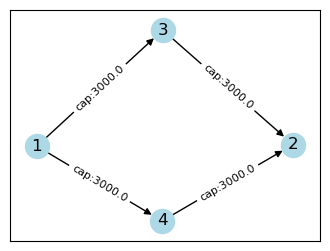

In [12]:
coordinates = np.array(list(zip(node['x_coord'],node['y_coord'])))
npos = dict(zip(gnode,coordinates))  # Get the mapping relationship between nodes and coordinates, represented as a dictionary
nlabels = dict(zip(gnode, gnode))

nx.draw_networkx_nodes(G, npos, node_color="lightblue")  # draw the nodes
nx.draw_networkx_edges(G, npos, glink)  # draw the edges(links)
nx.draw_networkx_labels(G, npos, nlabels)  # add labels

str_cap = ["cap:"+ str('%.1f'% i) for i in list(link['capacity'])]
edge_labels = dict(zip(glink, str_cap))

nx.draw_networkx_edge_labels(G, npos, edge_labels, font_size=8) # show the capacity

plt.rcParams['figure.figsize']= (4, 3) 

## 2.The main programme
After preparing the data, you can run the DTA module of path4GMNS, which is called in a very simple way as shown below.

In [13]:
cd .\08_UE_3_corridor_Network\minimum_input

C:\Users\Lenovo\path4GMNS_tutorial\08_UE_3_corridor_Network\minimum_input


In [14]:
pg.dtaapi.run_DTALite()


DTALite run starts

DTALite run completes!


In [15]:
!cd

C:\Users\Lenovo\path4GMNS_tutorial\08_UE_3_corridor_Network\minimum_input


You can ensure that the program is running correctly by outputting a list of files in the current directory (the directory where pg.dtaapi.run_DTALite is running) and comparing it to the reference output provided by the DTA-user-guide documentation.

In [16]:
files = os.listdir('.')
files

['agent.csv',
 'agent_0_base.csv',
 'agent_1_info.csv',
 'choice_set_output_0_base.csv',
 'choice_set_output_1_info.csv',
 'demand.csv',
 'demand_file_list.csv',
 'demand_period.csv',
 'departure_time_profile.csv',
 'district_performance_s0_base.csv',
 'district_performance_s1_info.csv',
 'DTALite.exe',
 'dynamic_traffic_management.csv',
 'final_summary.csv',
 'link.csv',
 'link_performance_s0_base.csv',
 'link_performance_s1_info.csv',
 'link_performance_summary.csv',
 'link_performance_summary_2way.csv',
 'link_type.csv',
 'log_DTA.txt',
 'log_dynamic_link_state.txt',
 'log_label_correcting.txt',
 'log_main.txt',
 'log_scenario.txt',
 'log_shortest_path_tree.csv',
 'log_simulation.txt',
 'log_subarea_focusing.txt',
 'log_traffic_assignment.csv',
 'model_link.csv',
 'model_node.csv',
 'mode_type.csv',
 'node.csv',
 'od_performance_summary.csv',
 'route_assignment_s0_base.csv',
 'route_assignment_s1_info.csv',
 'scenario_index_list.csv',
 'sensor_data.csv',
 'settings.csv',
 'subarea.c

## 3.Results
### a. Route assignment results
This result is output by the programme in route_assignment_[scenarioname].csv. This part presents the feasible routes between the OD pairs, the traffic assignment of each route after DTA, and other data such as route passing time.

In [17]:
columns_to_read = ['first_column', 'route_seq_id', 'o_zone_id', 'd_zone_id', 'o_super_zone_index', 'd_super_zone_index', 'od_pair_key', 
                   'information_type', 'mode_type', 'demand_period', 'volume', 'distance_km', 'distance_mile', 'travel_time', 'FFTT', 
                   'co2', 'nox', 'UE_OD_based_relative_gap_compared_to_least_time_path_travel_time', 'UE_path_based_gap', 
                   'preload_volume_from_route_input_file', 'ODME_volume_before', 'ODME_volume_after', 'ODME_volume_diff', 
                   'SIMU_volume', 'SIMU_travel_time', 'toll', 'number_of_nodes', 'node_sequence', 'link_id_sequence', 'geometry', 
                   'link_special_flag_sequence', 'sequential_link_delay', 'sequential_link_FFTT', 'DTM_OD_impact',
                   'DTM_TT_1', 'DTM_TT_2', 'DTM_TT_3', 'DTM_TT_4', 'DTM_TT_5', 'DTM_TT_6', 'DTM_TT_7', 'DTM_TT_8', 'DTM_TT_9', 'DTM_TT_10', 'DTM_Vol_0', 'DTM_Delta_Vol_1', 'DTM_Delta_Vol_2', 'DTM_Delta_Vol_3', 'DTM_Delta_Vol_4', 'DTM_Delta_Vol_5', 'DTM_Delta_Vol_6', 'DTM_Delta_Vol_7', 'DTM_Delta_Vol_8', 'DTM_Delta_Vol_9', 'DTM_Delta_Vol_10']

route_assignment_s0 = pd.read_csv('route_assignment_s0_base.csv',usecols=columns_to_read)#error_bad_lines=False)
route_assignment_s0

,first_column,route_seq_id,o_zone_id,d_zone_id,o_super_zone_index,d_super_zone_index,od_pair_key,information_type,mode_type,demand_period,...,DTM_Delta_Vol_1,DTM_Delta_Vol_2,DTM_Delta_Vol_3,DTM_Delta_Vol_4,DTM_Delta_Vol_5,DTM_Delta_Vol_6,DTM_Delta_Vol_7,DTM_Delta_Vol_8,DTM_Delta_Vol_9,DTM_Delta_Vol_10
0,NaN,1,1,2,0,1,1->2,0,auto,am7,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-2700.000050
1,NaN,2,1,2,0,1,1->2,0,info,am7,...,-43.649392,-32.737044,-26.189635,-21.824696,-18.706882,-16.368522,-14.549797,-13.094818,-11.90438,-35.500751
2,NaN,3,1,2,0,1,1->2,0,info,am7,...,43.649392,32.737044,26.189635,21.824696,18.706882,16.368522,14.549797,13.094818,11.90438,-264.499255
3,NaN,4,1,2,0,1,1->2,0,auto,am8,...,2700.000050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
4,NaN,5,1,2,0,1,1->2,0,info,am8,...,300.000006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
5,NaN,6,1,2,0,1,1->2,0,auto,am9,...,2700.000050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
6,NaN,7,1,2,0,1,1->2,0,info,am9,...,300.000006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
7,NaN,8,1,2,0,1,1->2,0,auto,am10,...,2700.000050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
8,NaN,9,1,2,0,1,1->2,0,info,am10,...,300.000006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


Use this function to correct route result:

In [18]:
def corr(route_df):
    # The original document has a line first_column, which will cause data misalignment merger
    # Here is to fix the problem of misalignment
    col=list(route_df.columns)
    col.remove('first_column')
    col.append('last')
    dic=dict(zip(list(route_df.columns),col))
    route=route_df.rename(columns=dic)
    return route

In [19]:
route= route_assignment_s0

Filter the data by column name to see the more intuitive and critical part of the route results. 

In [20]:
route[['route_seq_id','od_pair_key','demand_period','volume','travel_time','node_sequence','link_id_sequence','mode_type']]

,route_seq_id,od_pair_key,demand_period,volume,travel_time,node_sequence,link_id_sequence,mode_type
0,1,1->2,am7,2700.0000,106.4762,1;4;2;,1;2;,auto
1,2,1->2,am7,35.5008,106.4762,1;4;2;,1;2;,info
2,3,1->2,am7,264.4993,60.0000,1;3;2;,3;4;,info
3,4,1->2,am8,2700.0000,32.9524,1;4;2;,1;2;,auto
4,5,1->2,am8,300.0000,32.9524,1;4;2;,1;2;,info
5,6,1->2,am9,2700.0000,32.9524,1;4;2;,1;2;,auto
6,7,1->2,am9,300.0000,32.9524,1;4;2;,1;2;,info
7,8,1->2,am10,2700.0000,32.9524,1;4;2;,1;2;,auto
8,9,1->2,am10,300.0000,32.9524,1;4;2;,1;2;,info


Since you have given different mode types in the input file, it have generated different assignment results for each mode. 

In [21]:
route_auto=route[route['mode_type']=='auto']
route_auto[['route_seq_id','od_pair_key','mode_type','volume','travel_time','node_sequence','link_id_sequence','demand_period']]

,route_seq_id,od_pair_key,mode_type,volume,travel_time,node_sequence,link_id_sequence,demand_period
0,1,1->2,auto,2700.0,106.4762,1;4;2;,1;2;,am7
3,4,1->2,auto,2700.0,32.9524,1;4;2;,1;2;,am8
5,6,1->2,auto,2700.0,32.9524,1;4;2;,1;2;,am9
7,8,1->2,auto,2700.0,32.9524,1;4;2;,1;2;,am10


In [22]:
route_info=route[route['mode_type']=='info']
route_info[['route_seq_id','od_pair_key','mode_type','volume','travel_time','node_sequence','link_id_sequence','demand_period']]

,route_seq_id,od_pair_key,mode_type,volume,travel_time,node_sequence,link_id_sequence,demand_period
1,2,1->2,info,35.5008,106.4762,1;4;2;,1;2;,am7
2,3,1->2,info,264.4993,60.0000,1;3;2;,3;4;,am7
4,5,1->2,info,300.0000,32.9524,1;4;2;,1;2;,am8
6,7,1->2,info,300.0000,32.9524,1;4;2;,1;2;,am9
8,9,1->2,info,300.0000,32.9524,1;4;2;,1;2;,am10


And for different time period:

In [23]:
route_am7 = route[route['demand_period']=='am7']
route_am8 = route[route['demand_period']=='am8']
route_am9 = route[route['demand_period']=='am9']
route_am10 = route[route['demand_period']=='am10']

In [24]:
route_am7

,first_column,route_seq_id,o_zone_id,d_zone_id,o_super_zone_index,d_super_zone_index,od_pair_key,information_type,mode_type,demand_period,...,DTM_Delta_Vol_1,DTM_Delta_Vol_2,DTM_Delta_Vol_3,DTM_Delta_Vol_4,DTM_Delta_Vol_5,DTM_Delta_Vol_6,DTM_Delta_Vol_7,DTM_Delta_Vol_8,DTM_Delta_Vol_9,DTM_Delta_Vol_10
0,NaN,1,1,2,0,1,1->2,0,auto,am7,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-2700.000050
1,NaN,2,1,2,0,1,1->2,0,info,am7,...,-43.649392,-32.737044,-26.189635,-21.824696,-18.706882,-16.368522,-14.549797,-13.094818,-11.90438,-35.500751
2,NaN,3,1,2,0,1,1->2,0,info,am7,...,43.649392,32.737044,26.189635,21.824696,18.706882,16.368522,14.549797,13.094818,11.90438,-264.499255


Check out the route assignment result in time period am7 for mode auto and info.

In [25]:
route_am7_auto = route_am7[route_am7['mode_type']=='auto']
route_am7_info = route_am7[route_am7['mode_type']=='info']

In [26]:
route_am7_auto[['route_seq_id','od_pair_key','mode_type','volume','travel_time','node_sequence','link_id_sequence','demand_period']]

,route_seq_id,od_pair_key,mode_type,volume,travel_time,node_sequence,link_id_sequence,demand_period
0,1,1->2,auto,2700.0,106.4762,1;4;2;,1;2;,am7


In [27]:
route_am7_info[['route_seq_id','od_pair_key','mode_type','volume','travel_time','node_sequence','link_id_sequence','demand_period']]

,route_seq_id,od_pair_key,mode_type,volume,travel_time,node_sequence,link_id_sequence,demand_period
1,2,1->2,info,35.5008,106.4762,1;4;2;,1;2;,am7
2,3,1->2,info,264.4993,60.0000,1;3;2;,3;4;,am7


And for scenario 1, it is similar to the codes above.

In [28]:
route_s1 = pd.read_csv('route_assignment_s1_info.csv',usecols=columns_to_read)#error_bad_lines=False)
route_auto_s1=route_s1[route_s1['mode_type']=='auto']
route_auto_s1

,first_column,route_seq_id,o_zone_id,d_zone_id,o_super_zone_index,d_super_zone_index,od_pair_key,information_type,mode_type,demand_period,...,DTM_Delta_Vol_1,DTM_Delta_Vol_2,DTM_Delta_Vol_3,DTM_Delta_Vol_4,DTM_Delta_Vol_5,DTM_Delta_Vol_6,DTM_Delta_Vol_7,DTM_Delta_Vol_8,DTM_Delta_Vol_9,DTM_Delta_Vol_10
0,NaN,1,1,2,0,1,1->2,0,auto,am7,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1500.000028
3,NaN,4,1,2,0,1,1->2,0,auto,am8,...,1500.000028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,NaN,6,1,2,0,1,1->2,0,auto,am9,...,1500.000028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7,NaN,8,1,2,0,1,1->2,0,auto,am10,...,1500.000028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


### b. Link assignment results
This result is output by the program in link_assignment_[scenarioname].csv, presenting the assignment on the link.

In [29]:
link_performance_s0 = pd.read_csv('link_performance_s0_base.csv')
link_performance_s0

,link_seq_id,link_id,vdf_type,from_node_id,to_node_id,lanes,distance_km,distance_mile,fftt,meso_link_id,...,DTM_speed_before,DTM_speed_after,DTM_speed_diff,DTM_DoC_before,DTM_DoC_after,DTM_Doc_diff,DTM_P_before,DTM_P_after,DTM_P_diff,notes
0,1,1,bpr,1,4,1.0,15.0,9.322561,15.0,-1,...,10.000,10.000,0.0,9.99,9.99,0.0,0.627,0.627,0.0,period-based
1,1,1,bpr,1,4,1.0,15.0,9.322561,15.0,-1,...,54.624,54.624,0.0,0.90,0.90,0.0,0.627,0.627,0.0,period-based
2,1,1,bpr,1,4,1.0,15.0,9.322561,15.0,-1,...,54.624,54.624,0.0,0.90,0.90,0.0,0.627,0.627,0.0,period-based
3,1,1,bpr,1,4,1.0,15.0,9.322561,15.0,-1,...,54.624,54.624,0.0,0.90,0.90,0.0,0.627,0.627,0.0,period-based
4,2,2,bpr,4,2,1.0,15.0,9.322561,15.0,-1,...,54.624,54.624,0.0,0.90,0.90,0.0,0.627,0.627,0.0,period-based
5,2,2,bpr,4,2,1.0,15.0,9.322561,15.0,-1,...,54.624,54.624,0.0,0.90,0.90,0.0,0.627,0.627,0.0,period-based
6,2,2,bpr,4,2,1.0,15.0,9.322561,15.0,-1,...,54.624,54.624,0.0,0.90,0.90,0.0,0.627,0.627,0.0,period-based
7,2,2,bpr,4,2,1.0,15.0,9.322561,15.0,-1,...,54.624,54.624,0.0,0.90,0.90,0.0,0.627,0.627,0.0,period-based
8,3,3,bpr,1,3,1.0,30.0,18.645121,30.0,-1,...,60.000,60.000,0.0,0.00,0.00,0.0,0.000,0.000,0.0,period-based
9,3,3,bpr,1,3,1.0,30.0,18.645121,30.0,-1,...,60.000,60.000,0.0,0.00,0.00,0.0,0.000,0.000,0.0,period-based


In [30]:
link_performance_s0[['link_id','from_node_id','to_node_id','volume','time_period']]

,link_id,from_node_id,to_node_id,volume,time_period
0,1,1,4,2747.405,0700_0800
1,1,1,4,3000.000,0800_0900
2,1,1,4,3000.000,0900_1000
3,1,1,4,3000.000,1000_1100
4,2,4,2,2747.405,0700_0800
5,2,4,2,3000.000,0800_0900
6,2,4,2,3000.000,0900_1000
7,2,4,2,3000.000,1000_1100
8,3,1,3,252.595,0700_0800
9,3,1,3,0.000,0800_0900


With the link_performance file and network files(link.csv and node.csv), you can use the following code to get the network with assignment flow result on link. Also, you should check for the three pieces of time period separately.<br>
**But please note, that the description for the time period in this file is not 'demand_period' but 'time_period':**

In [31]:
link_am7_s0=link_performance_s0[link_performance_s0['time_period']=='0700_0800']  
link_am8_s0=link_performance_s0[link_performance_s0['time_period']=='0800_0900']  
link_am9_s0=link_performance_s0[link_performance_s0['time_period']=='0900_1000']  
link_am10_s0=link_performance_s0[link_performance_s0['time_period']=='1000_1100']  

In [32]:
link_am7_s0[['link_id','from_node_id','to_node_id','volume','time_period']]

,link_id,from_node_id,to_node_id,volume,time_period
0,1,1,4,2747.405,0700_0800
4,2,4,2,2747.405,0700_0800
8,3,1,3,252.595,0700_0800
12,4,3,2,252.595,0700_0800


In [33]:
link_am9_s0[['link_id','from_node_id','to_node_id','volume','time_period']]

,link_id,from_node_id,to_node_id,volume,time_period
2,1,1,4,3000.0,0900_1000
6,2,4,2,3000.0,0900_1000
10,3,1,3,0.0,0900_1000
14,4,3,2,0.0,0900_1000


With the link_performance file and network files(link.csv and node.csv), you can use the following code to get the network with assignment flow result on link.

In [34]:
def draw_res(link_s,link_performance_s):
    gnode = list(node['node_id'])
    glink = list(zip(link_s['from_node_id'],link_s['to_node_id']))
    G = nx.DiGraph()           # grapgh object
    G.add_nodes_from(gnode)
    G.add_edges_from(glink)

    coordinates = np.array(list(zip(node['x_coord'],node['y_coord'])))
    npos = dict(zip(gnode,coordinates))  # Get the mapping relationship between nodes and coordinates, represented as a dictionary
    nlabels = dict(zip(gnode, gnode))
    edge_labels = dict(zip(glink, list(link_performance_s['volume'])))

    nx.draw_networkx_nodes(G, npos, node_color="lightblue")  # draw the nodes
    nx.draw_networkx_edges(G, npos, glink)  # draw the edges(links)
    nx.draw_networkx_labels(G, npos, nlabels)  # add labels
    nx.draw_networkx_edge_labels(G, npos, edge_labels=edge_labels) # show the assignment flow result
    plt.rcParams['figure.figsize']= (4, 3) 

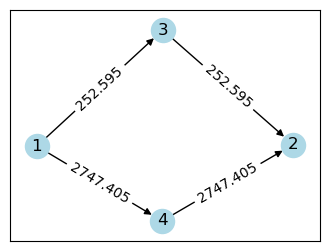

In [35]:
draw_res(link,link_am7_s0)

In [36]:
link_performance_s1 = pd.read_csv('link_performance_s1_info.csv')
link_performance_s1

,link_seq_id,link_id,vdf_type,from_node_id,to_node_id,lanes,distance_km,distance_mile,fftt,meso_link_id,...,DTM_speed_before,DTM_speed_after,DTM_speed_diff,DTM_DoC_before,DTM_DoC_after,DTM_Doc_diff,DTM_P_before,DTM_P_after,DTM_P_diff,notes
0,1,1,bpr,1,4,1.0,15.0,9.322561,15.0,-1,...,10.000,10.000,0.0,9.99,9.99,0.0,0.06,0.06,0.0,period-based
1,1,1,bpr,1,4,1.0,15.0,9.322561,15.0,-1,...,59.443,59.443,0.0,0.50,0.50,0.0,0.06,0.06,0.0,period-based
2,1,1,bpr,1,4,1.0,15.0,9.322561,15.0,-1,...,59.443,59.443,0.0,0.50,0.50,0.0,0.06,0.06,0.0,period-based
3,1,1,bpr,1,4,1.0,15.0,9.322561,15.0,-1,...,59.443,59.443,0.0,0.50,0.50,0.0,0.06,0.06,0.0,period-based
4,2,2,bpr,4,2,1.0,15.0,9.322561,15.0,-1,...,59.443,59.443,0.0,0.50,0.50,0.0,0.06,0.06,0.0,period-based
5,2,2,bpr,4,2,1.0,15.0,9.322561,15.0,-1,...,59.443,59.443,0.0,0.50,0.50,0.0,0.06,0.06,0.0,period-based
6,2,2,bpr,4,2,1.0,15.0,9.322561,15.0,-1,...,59.443,59.443,0.0,0.50,0.50,0.0,0.06,0.06,0.0,period-based
7,2,2,bpr,4,2,1.0,15.0,9.322561,15.0,-1,...,59.443,59.443,0.0,0.50,0.50,0.0,0.06,0.06,0.0,period-based
8,3,3,bpr,1,3,1.0,30.0,18.645121,30.0,-1,...,60.000,60.000,0.0,0.00,0.00,0.0,0.00,0.00,0.0,period-based
9,3,3,bpr,1,3,1.0,30.0,18.645121,30.0,-1,...,60.000,60.000,0.0,0.00,0.00,0.0,0.00,0.00,0.0,period-based


In [37]:
link_am7_s1=link_performance_s1[link_performance_s1['time_period']=='0700_0800'] 

In [38]:
link_am7_s1[['link_id','from_node_id','to_node_id','volume']]

,link_id,from_node_id,to_node_id,volume
0,1,1,4,1757.738
4,2,4,2,1757.738
8,3,1,3,1242.262
12,4,3,2,1242.262


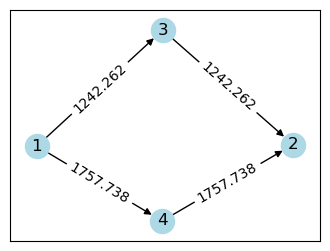

In [39]:
draw_res(link,link_am7_s1)

### c. Summary of results
The program outputs various items such as runtime information, assignment results, and system performance to the final_summary.csv file, through which you can get the complete results of each part of the program. 

In [40]:
col_names=[str(i) for i in range(12)]
data = pd.read_csv('final_summary.csv',header=None,names=col_names)

In [41]:
display(data.to_string()) # You can take this approach if you want to see the full table, but it's rather unintuitive

'                                                                                                                                          0                                                                                                                                        1                                                    2                                3                                   4                       5                    6                    7                   8               9                 10                   11\n0                                                                                    [PROCESS INFO] Step 0: reading scenario_index_list.csv                                                                                                                                      NaN                                                  NaN                              NaN                                 NaN                     NaN                  NaN              